In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
from scipy import stats

from utils import cellular_automaton

In [ ]:
sns.set_theme("paper")
sns.set_style("white")
matplotlib.rc("text", usetex=True)
plt.rc("font", family="serif")

In [ ]:
COLORS = [
    "#0072BD",  # blue
    "#D95319",  # orange
    "#EDB120",  # yellow
    "#7E2F8E",  # purple
    "#77AC30",  # green
    "#4DBEEE",  # light blue
    "#A2142F",  # dark red
]

# Load data

In [ ]:
# arc_e_data = pd.read_csv("data/arc_e_results.csv")
# arc_h_data = pd.read_csv("data/arc_h_results.csv")
chess_data = pd.read_csv("data/chess_results_new.csv")
rule_complexity = pd.read_csv("data/rule_complexities.csv")
rule_classes = pd.read_csv("data/rule_wolfram_classes.csv")
long_short_data = pd.read_csv("data/long_short_term_data.csv")

In [ ]:
chess_data = chess_data[pd.to_numeric(chess_data["Rule"], errors='coerce').notnull()]
arc_e_data = arc_e_data[pd.to_numeric(arc_e_data["Rule"], errors='coerce').notnull()]
arc_h_data = arc_h_data[pd.to_numeric(arc_h_data["Rule"], errors='coerce').notnull()]
long_short_data = long_short_data[pd.to_numeric(long_short_data["Rule"], errors='coerce').notnull()]

chess_data["Rule"] = chess_data["Rule"].astype(int)
arc_e_data["Rule"] = arc_e_data["Rule"].astype(int)
arc_h_data["Rule"] = arc_h_data["Rule"].astype(int)
long_short_data["Rule"] = long_short_data["Rule"].astype(int)

In [ ]:
complexities_to_keep = {
    "Krylov Complexity": "Krylov",
    "Lempel-Ziv Complexity": "Lempel-Ziv",
    "Compression Complexity": "Compression",
    "Shannon Entropy": "Shannon Entropy",
    "Fractal Dimension": "Fractal Dimension",
    "Krylov Complexity Rank": "Krylov Rank",
    "Lempel-Ziv Complexity Rank": "Lempel-Ziv Rank",
    "Compression Complexity Rank": "Compression Rank",
    "Shannon Entropy Rank": "Shannon Entropy Rank",
    "Fractal Dimension Rank": "Fractal Dimension Rank",
    "LE": "Lyapunov",
    "LE rank": "Lyapunov Rank",
    "LZ integral": "Lempel-Ziv integral",
}

In [ ]:
# goal: first pc should capture most of the variation in the complexity measures
complexities_to_use_for_pca = [
    "Compression Complexity",
    "Fractal Dimension",
    "Krylov Complexity",
    "LE",
    "Lempel-Ziv Complexity",
]

## Process ARC data

In [ ]:
merged_arc_data = arc_e_data[['Rule', 'thres_80']].merge(
    arc_h_data[['Rule', 'thres_80']],
    on='Rule',
    suffixes=('_arc_e', '_arc_h'),
    how="outer"
).merge(
    rule_complexity[list(complexities_to_keep.keys()) + ["Rule"]],
    on="Rule"
).merge(
    rule_classes[['Rule', 'Classification']],
    on="Rule"
)

class_mapping = {
    "Class I": 1,
    "Class II": 2,
    "Class III": 3,
    "Class IV": 4
}
merged_arc_data['Wolfram Class'] = merged_arc_data['Classification'].map(class_mapping)
merged_arc_data.drop(columns=["Classification"], inplace=True)

merged_arc_data.head()

In [ ]:
merged_arc_data = arc_e_data[['Rule', 'thres_80']].merge(
    arc_h_data[['Rule', 'thres_80']],
    on='Rule',
    suffixes=('_arc_e', '_arc_h'),
    how="outer"
)

merged_data = arc_e_data[['Rule', 'thres_80']].merge(
    arc_h_data[['Rule', 'thres_80']],
    on='Rule',
    suffixes=('_arc_e', '_arc_h')
).merge(
    chess_data[['Rule', 'best_val_acc']],
    on='Rule'
).merge(
    rule_complexity[complexities_to_keep + ["Rule"]],
    on="Rule"
).merge(
    rule_classes[['Rule', 'Classification']],
    on="Rule"
).merge(
    long_short_data[['Rule', 'thres_80_k1', 'thres_80_k5']],
    on="Rule"
)


print(len(merged_data))
merged_data.head()

In [ ]:
merged_arc_data['arc_e_efficiency'] = 1 / merged_arc_data['thres_80_arc_e']
merged_arc_data['arc_h_efficiency'] = 1 / merged_arc_data['thres_80_arc_h']
merged_arc_data.head()

In [ ]:
merged_arc_data = merged_arc_data[merged_arc_data["Rule"] != 0]

## Process Chess data

In [ ]:
print(len(chess_data))
chess_data.head()

In [ ]:
merged_chess_data = chess_data[['Rule', 'best_val_acc']].merge(
    rule_complexity[list(complexities_to_keep.keys()) + ["Rule"]],
    on="Rule"
).merge(
    rule_classes[['Rule', 'Classification']],
    on="Rule"
)

merged_chess_data['Wolfram Class'] = merged_chess_data['Classification'].map(class_mapping)
merged_chess_data.drop(columns=["Classification"], inplace=True)
merged_chess_data = merged_chess_data[merged_chess_data["Rule"] != 0]

merged_chess_data.head()

# Simple mockups for Figure 1

In [ ]:
plt.figure(figsize=(8, 6))
four_colors = [
    "#84E291",
    "#A6CAEC",
    "#F6C6AD",
    "#C9BBE5"
]

# Define the bins and labels
bins = np.array([20, 40, 65, 92])

# Assign each data point to a bin
bins = np.digitize(merged_arc_data["Lempel-Ziv Complexity"], bins) - 1

# Map the bin numbers to colors
c = [four_colors[i] for i in bins]

plt.scatter(merged_arc_data["Lempel-Ziv Complexity"], merged_arc_data['arc_e_efficiency'], color=COLORS[0], s=200, edgecolors='k', linewidths=1, alpha=1)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig("figures/complexity_vs_perf_simple.png", dpi=300)

In [ ]:
chess_acc_by_class = merged_chess_data.groupby('Wolfram Class')['best_val_acc'].apply(list).tolist()

plt.figure(figsize=(6, 4))
sns.violinplot(chess_acc_by_class, color=COLORS[0], saturation=1)

plt.xticks([0, 1, 2, 3], ["I", "II", "III", "IV"], fontsize="x-large")
plt.yticks([])

plt.tight_layout()
plt.savefig("figures/complexity_vs_class_simple.png", dpi=300)


# Figure 2: Complexity vs Performance for different complexity measures

In [476]:
len(x1)

74

In [477]:
len(y1)

73

In [482]:
len(all_arc_e["arc_e_efficiency"].to_numpy())

73

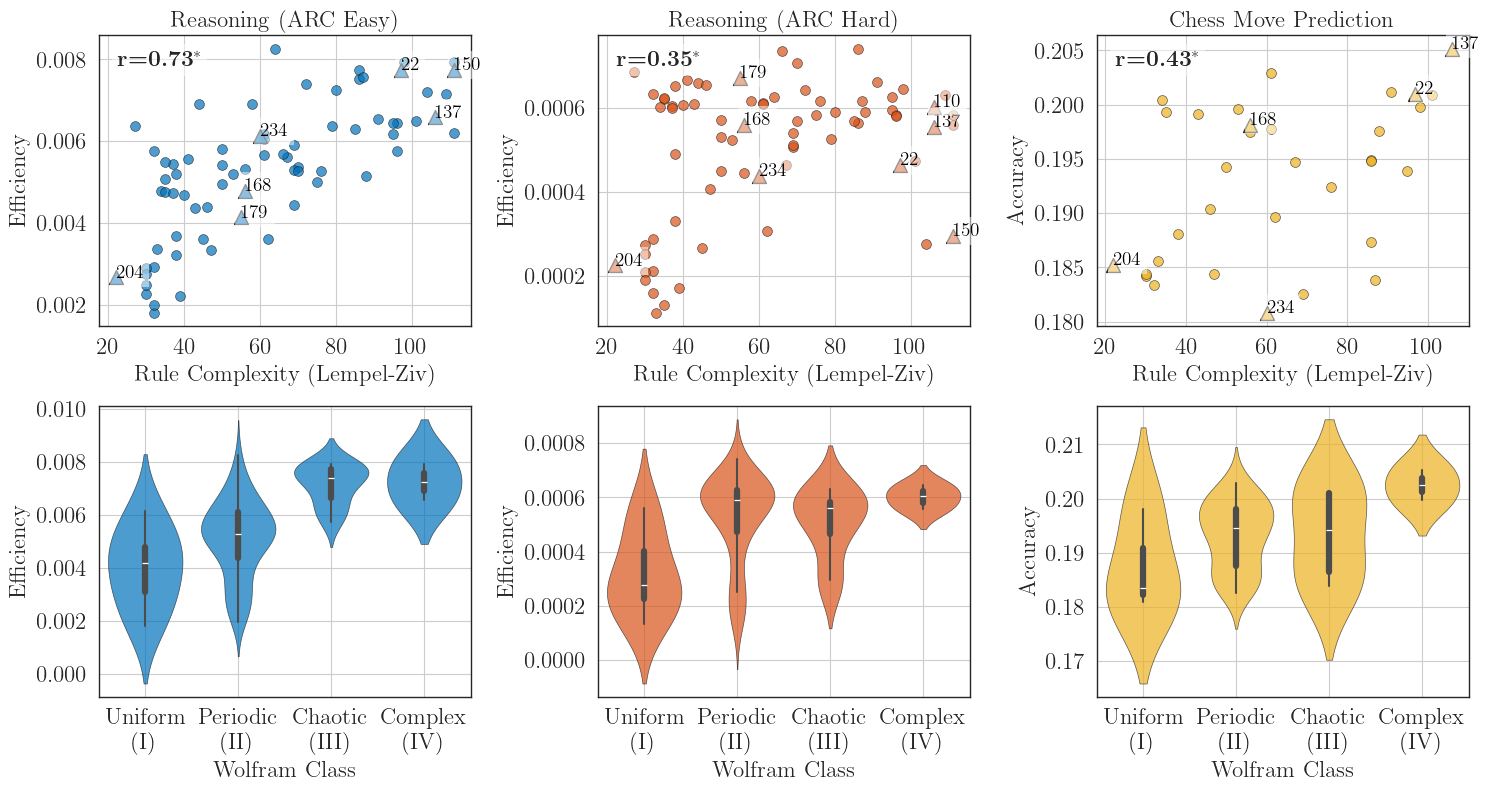

In [484]:
rules_to_show = [168, 179, 150, 110, 234, 204, 22, 137]
for complexity_measure in ["Lempel-Ziv Complexity"]:  #complexities_to_keep:
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    complexity_name = complexities_key_to_name[complexity_measure]

    # ARC-E
    all_arc_e = merged_arc_data.dropna(subset=["arc_e_efficiency"])

    tmp = all_arc_e[~all_arc_e['Rule'].isin(rules_to_show)]
    x1 = tmp[complexity_measure]
    y1 = tmp["arc_e_efficiency"]

    axs[0, 0].scatter(x1, y1, color=COLORS[0], s=50, edgecolors='k', linewidths=0.5, alpha=0.7)
    axs[0, 0].set_title('Reasoning (ARC Easy)', fontsize="xx-large")
    axs[0,0].set_xlabel(f'Rule Complexity ({{{complexity_name}}})', fontsize="xx-large")
    axs[0,0].set_ylabel('Efficiency', fontsize="xx-large")
    axs[0,0].grid()

    rules_to_show_data = merged_arc_data[merged_arc_data['Rule'].isin(rules_to_show)]
    axs[0,0].scatter(
        rules_to_show_data[complexity_measure],
        rules_to_show_data["arc_e_efficiency"],
        marker="^", color=COLORS[0], s=100, edgecolors='k', linewidths=1, alpha=0.9
    )
    for _, row in rules_to_show_data.iterrows():
        axs[0,0].annotate(
            f'{int(row["Rule"])}',
            (row[complexity_measure], row["arc_e_efficiency"]),
            fontsize="x-large", color='black', weight='bold',
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))

    correlation, p_value = stats.pearsonr(all_arc_e[complexity_measure], all_arc_e["arc_e_efficiency"])
    corr = f"$\\textbf{{r={{{correlation:.2f}}}}}^*$" if p_value < 0.05 else f"$\\textbf{{r={{{correlation:.4f}}}}}$"
    axs[0,0].text(0.05, 0.95, corr, transform=axs[0,0].transAxes, fontsize="xx-large",
               verticalalignment='top', horizontalalignment='left',
               bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # ARC-H
    all_arc_h = merged_arc_data.dropna(subset=["arc_h_efficiency"])

    tmp = tmp[~tmp['Rule'].isin(rules_to_show)]
    x2 = tmp[complexity_measure]
    y2 = tmp["arc_h_efficiency"]
    axs[0,1].scatter(x2, y2, color=COLORS[1], s=50, edgecolors='k', linewidths=0.5, alpha=0.7)
    axs[0,1].set_title('Reasoning (ARC Hard)', fontsize="xx-large")
    axs[0,1].set_xlabel(f'Rule Complexity ({{{complexity_name}}})', fontsize="xx-large")
    axs[0,1].set_ylabel('Efficiency', fontsize="xx-large")
    axs[0,1].grid()

    rules_to_show_data = merged_arc_data[merged_arc_data['Rule'].isin(rules_to_show)]
    axs[0,1].scatter(
        rules_to_show_data[complexity_measure],
        rules_to_show_data["arc_h_efficiency"],
        marker="^",
        color=COLORS[1], s=100, edgecolors='k', linewidths=1, alpha=0.9
    )
    for _, row in rules_to_show_data.iterrows():
        axs[0,1].annotate(
            f'{int(row["Rule"])}',
            (row[complexity_measure], row["arc_h_efficiency"]),
            fontsize="x-large", color='black', weight='bold',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
        )

    correlation, p_value = stats.pearsonr(all_arc_h[complexity_measure], all_arc_h["arc_h_efficiency"])
    corr = f"$\\textbf{{r={{{correlation:.2f}}}}}^*$" if p_value < 0.05 else f"$\\textbf{{r={{{correlation:.4f}}}}}$"
    axs[0,1].text(0.05, 0.95, corr, transform=axs[0,1].transAxes, fontsize="xx-large",
               verticalalignment='top', horizontalalignment='left',
               bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Chess
    all_chess = merged_chess_data
    
    tmp = merged_chess_data[~merged_chess_data['Rule'].isin(rules_to_show)]
    x3 = tmp[complexity_measure].dropna()
    y3 = tmp["best_val_acc"].dropna()
    axs[0,2].scatter(x3, y3, color=COLORS[2], s=50, edgecolors='k', linewidths=0.5, alpha=0.7)
    axs[0,2].set_title('Chess Move Prediction', fontsize="xx-large")
    axs[0,2].set_xlabel(f'Rule Complexity ({{{complexity_name}}})', fontsize="xx-large")
    axs[0,2].set_ylabel('Accuracy', fontsize="xx-large")
    axs[0,2].grid()

    rules_to_show_data = merged_chess_data[merged_chess_data['Rule'].isin(rules_to_show)]
    axs[0,2].scatter(
        rules_to_show_data[complexity_measure],
        rules_to_show_data["best_val_acc"],
        marker="^",
        color=COLORS[2], s=100, edgecolors='k', linewidths=1, alpha=0.9
    )
    for _, row in rules_to_show_data.iterrows():
        axs[0,2].annotate(
            f'{int(row["Rule"])}',
            (row[complexity_measure], row["best_val_acc"]),
            fontsize="x-large", color='black', weight='bold',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
        )

    correlation, p_value = stats.pearsonr(all_chess[complexity_measure], all_chess["best_val_acc"])
    corr = f"$\\textbf{{r={{{correlation:.2f}}}}}^*$" if p_value < 0.05 else f"$\\textbf{{r={{{correlation:.4f}}}}}$"
    axs[0,2].text(0.05, 0.95, corr, transform=axs[0,2].transAxes, fontsize="xx-large",
               verticalalignment='top', horizontalalignment='left',
               bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    for ax in axs[0]:
        ax.tick_params(axis='both', labelsize='xx-large')

    # By Wolfram Class
    arc_e_efficiency_by_class = merged_arc_data.dropna(subset=["arc_e_efficiency"]).groupby('Wolfram Class')['arc_e_efficiency'].apply(list).tolist()
    arc_h_efficiency_by_class = merged_arc_data.dropna(subset=["arc_h_efficiency"]).groupby('Wolfram Class')['arc_h_efficiency'].apply(list).tolist()
    chess_acc_by_class = merged_chess_data.dropna(subset=["best_val_acc"]).groupby('Wolfram Class')['best_val_acc'].apply(list).tolist()

    sns.violinplot(arc_e_efficiency_by_class, ax=axs[1,0])
    # axs[0].set_title('Reasoning (ARC Easy)', fontsize="xx-large")
    axs[1,0].set_xlabel('Wolfram Class', fontsize="xx-large")
    axs[1,0].set_ylabel('Efficiency', fontsize="xx-large")
    axs[1,0].grid()

    sns.violinplot(arc_h_efficiency_by_class, ax=axs[1,1])
    # axs[1].set_title('Reasoning (ARC Hard)', fontsize="xx-large")
    axs[1,1].set_xlabel('Wolfram Class', fontsize="xx-large")
    axs[1,1].set_ylabel('Efficiency', fontsize="xx-large")
    axs[1,1].grid()

    sns.violinplot(chess_acc_by_class, ax=axs[1,2])
    # axs[2].set_title('Chess Move Prediction', fontsize="xx-large")
    axs[1,2].set_xlabel('Wolfram Class', fontsize="xx-large")
    axs[1,2].set_ylabel('Accuracy', fontsize="xx-large")
    axs[1,2].grid()

    for i, ax in enumerate(axs[1]):
        ax.tick_params(axis='both', labelsize='xx-large')
        ax.set_xticks([0, 1, 2, 3], ["Uniform\n(I)", "Periodic\n(II)", "Chaotic\n(III)", "Complex\n(IV)"])
        for pc in ax.collections:
            pc.set(facecolor=COLORS[i], edgecolor="k", alpha=0.7, linewidth=0.5)

    plt.tight_layout()
    plt.savefig(f"figures/complexity_vs_perf/pdf/{complexity_measure}_vs_performance.pdf", bbox_inches="tight", dpi=300)
    plt.savefig(f"figures/complexity_vs_perf/png/{complexity_measure}_vs_performance.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot of Lempel-Ziv Complexity vs ARC Hard Efficiency
scatter = ax[0].scatter(merged_arc_data['Lempel-Ziv Complexity'], merged_arc_data['arc_h_efficiency'], 
                     c=merged_arc_data['Wolfram Class'], s=50, alpha=0.7, edgecolors='k', 
                     linewidths=0.5, cmap='viridis', label="ECA Rules")

# Annotate each point with the rule number
for i, (x, y, rule) in enumerate(zip(merged_arc_data['Lempel-Ziv Complexity'], merged_arc_data['arc_h_efficiency'], merged_arc_data['Rule'])):
    ax[0].annotate(rule, (x, y), fontsize='medium')

# Scatter plot of Lempel-Ziv Complexity vs Chess Accuracy
scatter = ax[1].scatter(merged_chess_data['Lempel-Ziv Complexity'], merged_chess_data['best_val_acc'], 
                     c=merged_chess_data['Wolfram Class'], s=50, alpha=0.7, edgecolors='k', 
                     linewidths=0.5, cmap='viridis', label="ECA Rules")

# Annotate each point with the rule number
for i, (x, y, rule) in enumerate(zip(merged_chess_data['Lempel-Ziv Complexity'], merged_chess_data['best_val_acc'], merged_chess_data['Rule'])):
    ax[1].annotate(rule, (x, y), fontsize='medium')

plt.tight_layout()
plt.show()


In [ ]:
merged_arc_data.loc[merged_arc_data['Rule'].isin(rules_to_show), 'Wolfram Class']

In [ ]:
merged_arc_data.loc[merged_arc_data["Rule"] == rule, "Wolfram Class"].values[0]

In [ ]:
sorted_rules = sorted(rules_to_show, key=lambda rule: merged_arc_data.loc[merged_arc_data["Rule"] == rule, "Wolfram Class"].values[0])

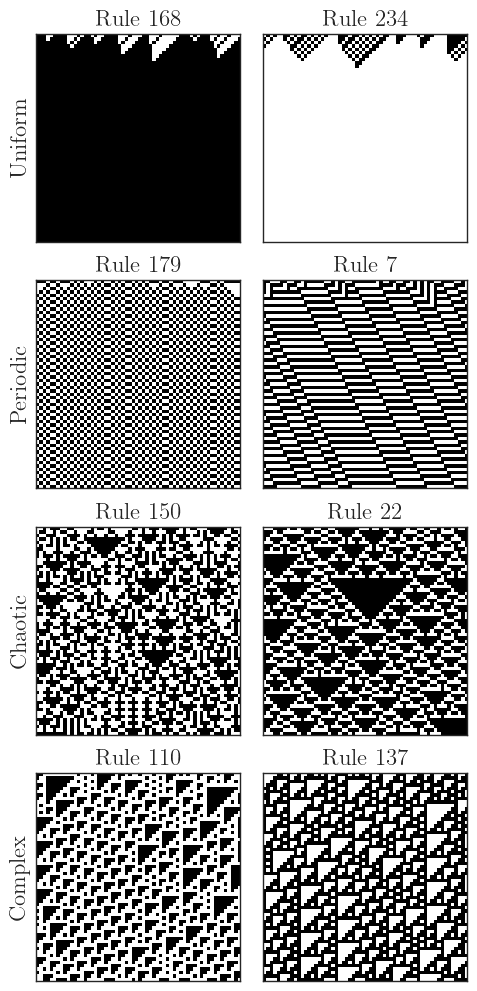

In [473]:
row1 = [168, 179, 150, 110]
row2 = [234, 7, 22, 137]

fig, ax = plt.subplots(4, 2, figsize=(5, 10))

class_mapping = {
    1: "Uniform",
    2: "Periodic",
    3: "Chaotic",
    4: "Complex",
}

for i, row in enumerate([row1, row2]):
    for j, rule in enumerate(row):
        rule_img = cellular_automaton(rule, width=60, steps=60, init="random")
        ax[j, i].imshow(rule_img, cmap="gray")
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].set_title(f"Rule {rule}", fontsize="xx-large")
        if i == 0:
            ax[j, i].set_ylabel(f"{class_mapping[j+1]}", fontsize="xx-large")

plt.tight_layout()
plt.savefig("figures/rule_images/rule_images.pdf", bbox_inches="tight", dpi=300)
plt.savefig("figures/rule_images/rule_images.png", bbox_inches="tight", dpi=300)
plt.show()


# Figure 5: Short vs Long Term Efficiency

In [ ]:
data = pd.read_csv("data/long_short_term_data.csv").merge(rule_complexity[complexities_to_keep + ["Rule"]], on='Rule')
short_term_efficiency = 1 / data['thres_80_k1']
long_term_efficiency = 1 / data['thres_80_k5']

In [ ]:
for complexity_measure in ["Lempel-Ziv Complexity"]:
    complexity = data[complexity_measure]
    complexity_name = complexities_key_to_name[complexity_measure]

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(7.25, 5))
    scatter = ax.scatter(short_term_efficiency, long_term_efficiency, 
                        c=complexity, s=50, alpha=0.7, edgecolors='k', 
                        linewidths=0.5, cmap='viridis', label="ECA Rules")

    # ax.set_title('Short and Long Term Prediction on ARC-E', fontsize="xx-large")
    ax.set_xlabel('Performance of Model Trained on Short-term Prediction', fontsize="large")
    ax.set_ylabel('Performance of Model Trained on Long-term Prediction', fontsize="large")

    # Determine the range for the y=x line
    x_min = short_term_efficiency.min() - 0.001
    x_max = short_term_efficiency.max() + 0.001
    y_min = long_term_efficiency.min() - 0.001
    y_max = long_term_efficiency.max() + 0.001

    line_min = 0
    line_max = 1

    # Plot the y=x line within the data range
    ax.plot([line_min, line_max], [line_min, line_max], color='darkgray', linestyle='--', label="y=x")

    ax.set_xlim(0, 0.01)
    ax.set_ylim(0, 0.01)
    ax.grid()

    ax.legend(fontsize="x-large")

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.ax.tick_params(labelsize="large")
    cbar.ax.set_ylabel(f'Rule Complexity ({{{complexity_name}}})', fontsize="x-large")

    ax.tick_params(axis='both', labelsize='large')

    plt.tight_layout()
    # plt.savefig(f"figures/long_vs_short/complexity_colored/short_long_term_efficiency_{complexity_measure}.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
for complexity_measure in complexities_to_keep:
    complexity = data[complexity_measure]
    complexity_name = complexities_key_to_name[complexity_measure]

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(
        data["Lempel-Ziv Complexity"],
        np.log(long_term_efficiency / short_term_efficiency),
        s=50, edgecolors='k', linewidths=0.5
    )

    # ax.set_title('Short and Long Term Prediction on ARC-E', fontsize="xx-large")
    ax.set_xlabel(f'Complexity ({{{complexity_name}}})', fontsize="x-large")
    ax.set_ylabel('Log ratio of long to short term efficiency', fontsize="x-large")

    ax.grid()
    ax.tick_params(axis='both', labelsize='large')

    plt.axhline(y=0, color='darkgray', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.savefig(f"figures/long_vs_short/log_ratio/log_ratio_{complexity_measure}.pdf", dpi=300)
    plt.close()